# RLLAB setup scripts for google colab
Install packages with compatible versions

In [0]:
!apt-get -qq install -y xvfb python-opengl > /dev/null 2>&1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg > /dev/null

In [0]:
!pip install -q path.py
!pip install -q pyprind
!pip install -q cached_property
!pip install -q gym==0.7.4
!pip install -q theano==0.8.2
!pip install -q git+https://github.com/neocxi/Lasagne.git@484866cf8b38d878e92d521be445968531646bb8#egg=Lasagne
  
!pip install -q PyOpenGL piglet pyglet pyvirtualdisplay

In [0]:
!pip install box2d-py mako==1.0.7 Pygame JSAnimation imageio

In [0]:
!git clone https://github.com/kekim/rllab.git rllab-git

In [0]:
!cp -a ./rllab-git/* .

# DQN Plus on Acrobot (OpenAI Gym version)
**Important!**
Before running the following cell, make sure rllab is set up properly in your current runtime by executing codes in RLLAB setup scripts.

**1. Implement DQN Plus (DDQN w/ Prioritized Experience Replay) Algorithm**

- Import necessary packages
(Execute **once again** if you encounter an error)

In [0]:
########## DQN_Plus_GYM_CARTPOLE_With_RUN_EXP_LITE ##########
from rllab.envs.gym_env import GymEnv
from dqn.policies.categorical_mlp_q_policy import CategoricalMlpQPolicy
from dqn.exploration_strategies.eps_greedy_strategy import EpsilonGreedyStrategy

# from dqn.algos.dqn import DQN

from rllab.envs.normalized_env import normalize
from rllab.misc.instrument import run_experiment_lite
from rllab.q_functions.continuous_mlp_q_function import ContinuousMLPQFunction

import lasagne.nonlinearities as NL
'''
import gym.envs
from rllab.envs.gym_env import GymEnv
from envs.proxy_gym_env import ProxyGymEnv
from misc.retro_wrappers import wrap_deepmind_retro
from policies.categorical_mlp_q_policy import CategoricalMlpQPolicy
from exploration_strategies.eps_greedy_strategy import EpsilonGreedyStrategy

from algos.dqn import DQN

from rllab.envs.normalized_env import normalize
from rllab.misc.instrument import run_experiment_lite
from rllab.q_functions.continuous_mlp_q_function import ContinuousMLPQFunction

import lasagne.nonlinearities as NL
'''

- Implement DQN Plus algorithm

In [0]:
from rllab.algos.base import RLAlgorithm
from rllab.misc.overrides import overrides
from rllab.misc import special
from rllab.misc import ext
from rllab.sampler import parallel_sampler
from rllab.plotter import plotter
from functools import partial
import rllab.misc.logger as logger
import theano.tensor as TT
import pickle as pickle
import numpy as np
import pyprind
import lasagne
from collections import deque
from rllab.algos.ddpg import parse_update_method#, SimpleReplayPool
from scipy.stats import rankdata

def huber_loss(diffs, clip):
    return TT.mean(TT.switch(abs(diffs) < clip, 0.5 * TT.square(diffs), clip * (abs(diffs) - 0.5 * clip)))
    

class PriorityReplayPool(object):
    def __init__(
            self, max_pool_size, observation_dim, action_dim, alpha, beta, n_steps):
        self._observation_dim = observation_dim
        self._action_dim = action_dim
        self._max_pool_size = max_pool_size
        self._observations = np.zeros(
            (max_pool_size, observation_dim),
        )
        self._actions = np.zeros(
            (max_pool_size, action_dim),
        )
        self._rewards = np.zeros(max_pool_size)
        self._terminals = np.zeros(max_pool_size, dtype='uint8')

        self._td_errs = np.zeros(max_pool_size)
        self._ranks = np.zeros(max_pool_size)
        self._probs = np.zeros(max_pool_size)
        self._weights = np.zeros(max_pool_size)#np.zeros(max_pool_size)
        
        # A scheduler is requried to make Alpha & Beta reach 1 at the end of training
        self._alpha = alpha
        self._beta = beta
        self._beta_increment = 2*(1.0-beta)/n_steps
        # self._beta_increment = 0.002#0.0000075#0.0000015#

        self._bottom = 0
        self._top = 0
        self._size = 0
        self._actual_size=0
        self._max_pool_size = max_pool_size

    def add_sample(self, observation, action, reward, terminal):
        if self._actual_size < self._max_pool_size:
            self._actual_size += 1

        self._observations[self._top] = observation
        self._actions[self._top] = action
        self._rewards[self._top] = reward
        self._terminals[self._top] = terminal

        self._td_errs[self._top] = np.max([np.max(self._td_errs), 0.000001])
        # self._td_errs[self._top] = np.max(self._td_errs)
        # self._weights[self._top] = np.max(self._weights)

        self._top = (self._top + 1) % self._max_pool_size
        if self._size >= self._max_pool_size:
            self._bottom = (self._bottom + 1) % self._max_pool_size
        else:
            self._size += 1

    def update_samples(self, td_errs, indices):
        # Sample update should be done in batch
        self._td_errs[indices] = td_errs+0.000001
        # print('td_erros:', self._td_errs.shape)

    def update_all(self):

        self._probs = np.power(self._td_errs, self._alpha)
        self._probs = self._probs / np.sum(self._probs)
        # print(self._probs)
        self._weights = np.power(self._actual_size*self._probs, (-1.0)*self._beta)
        self._weights = self._weights / np.max(self._weights)
        '''
        self._ranks[:self._actual_size] = rankdata(self._td_errs[:self._actual_size], method='min')
        self._probs[:self._actual_size] = np.power(1.0/self._ranks[:self._actual_size], self._alpha)
        self._probs = self._probs / np.sum(self._probs)
        self._weights = np.power(self._actual_size*self._probs, (-1.0)*self._beta)
        self._weights = self._weights / np.max(self._weights)
        '''

    def priority_batch(self, batch_size):
        assert self._size > batch_size

        self.update_all()

        indices = np.random.choice(self._max_pool_size,
                                    batch_size+1,
                                    replace=False,
                                    p=self._probs)
        # print(self._probs[self._actual_size])
        if self._size > self._max_pool_size:
            indices = indices[:batch_size]
        else:
            temp = np.where(indices == self._size-1)[0]
            if temp.shape[0] == 0:
                indices = indices[:batch_size]
            else:
                indices = np.delete(indices, temp[0])

        assert indices.shape[0] == batch_size

        transition_indices = (indices+1) % self._max_pool_size

        # Annealing bias by incrementing beta... Careful consideration is requried.
        self._beta = np.min([1.0, self._beta + self._beta_increment])

        return dict(
            observations=self._observations[indices],
            actions=self._actions[indices],
            rewards=self._rewards[indices],
            terminals=self._terminals[indices],
            indices=indices,
            weights=self._weights[indices],
            next_observations=self._observations[transition_indices]
        )


    @property
    def size(self):
        return self._size


class DQN_PLUS(RLAlgorithm):
    """
    Deep Q Network
    """

    def __init__(
            self,
            env,
            policy,
            es,
            batch_size=32,
            alpha=0.6,
            beta=0.4,
            n_steps=8000000,
            min_pool_size=1000000,
            replay_pool_size=1000000,
            discount=0.99,
            policy_update_method='adam',
            policy_learning_rate=1e-3,
            target_model_update=10000,
            n_updates_per_sample=1,
            train_epoch_interval=10000,
            max_path_length=np.inf,
            n_eval_samples=5,
            delta_clip=np.inf,
            include_horizon_terminal_transitions=False,
            plot=False,
            pause_for_plot=False):
        """
        :param env: Environment
        :param policy: Policy
        :param qf: Q function
        :param es: Exploration strategy
        :param batch_size: Number of samples for each minibatch.
        :param n_epochs: Number of epochs. Policy will be evaluated after each epoch.
        :param epoch_length: How many timesteps for each epoch.
        :param min_pool_size: Minimum size of the pool to start training.
        :param replay_pool_size: Size of the experience replay pool.
        :param discount: Discount factor for the cumulative return.
        :param max_path_length: Discount factor for the cumulative return.
        :param qf_weight_decay: Weight decay factor for parameters of the Q function.
        :param qf_update_method: Online optimization method for training Q function.
        :param qf_learning_rate: Learning rate for training Q function.
        :param policy_weight_decay: Weight decay factor for parameters of the policy.
        :param policy_update_method: Online optimization method for training the policy.
        :param policy_learning_rate: Learning rate for training the policy.
        :param n_eval_samples: Number of samples (timesteps) for evaluating the policy.
        :param soft_target_tau: Interpolation parameter for doing the soft target update.
        :param n_updates_per_sample: Number of Q function and policy updates per new sample obtained
        :param scale_reward: The scaling factor applied to the rewards when training
        :param include_horizon_terminal_transitions: whether to include transitions with terminal=True because the
        horizon was reached. This might make the Q value back up less stable for certain tasks.
        :param plot: Whether to visualize the policy performance after each train_epoch_interval.
        :param pause_for_plot: Whether to pause before continuing when plotting.
        :return:
        """
        self.env = env
        self.policy = policy
        self.es = es
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        self.min_pool_size = min_pool_size
        self.replay_pool_size = replay_pool_size
        self.discount = discount
        self.n_steps = n_steps
        
        self.policy_learning_rate = policy_learning_rate
        self.policy_update_method = parse_update_method(
                policy_update_method,
                learning_rate=policy_learning_rate,
        )
        
        assert target_model_update >= 0
        if target_model_update >= 1:
            self.target_model_update = int(target_model_update) # hard update every xx steps
        else:
            self.target_model_update = float(target_model_update) # soft update
            
        self.n_updates_per_sample = n_updates_per_sample
        self.train_epoch_interval = train_epoch_interval
        self.max_path_length = max_path_length
        self.n_eval_samples = n_eval_samples
        self.delta_clip = delta_clip
        
        self.include_horizon_terminal_transitions = include_horizon_terminal_transitions
        self.plot = plot
        self.pause_for_plot = pause_for_plot

        self.qf_loss_averages = []
        self.q_averages = []
        self.y_averages = []
        self.paths = []
        self.es_path_returns = []
        self.paths_samples_cnt = 0

        self.opt_info = None

    def start_worker(self):
        parallel_sampler.populate_task(self.env, self.policy)
        if self.plot:
            plotter.init_plot(self.env, self.policy)

    @overrides
    def train(self):
        # This seems like a rather sequential method
        pool = PriorityReplayPool(
        # pool = SimpleReplayPool(
            max_pool_size=int(self.replay_pool_size),
            observation_dim=self.env.observation_space.flat_dim,
            action_dim=self.env.action_space.flat_dim,
            alpha=self.alpha,
            beta=self.beta,
            n_steps=self.n_steps
        )
            
        self.start_worker()

        self.init_opt()
        itr = 0
        path_length = 0
        path_return = 0
        terminal = False
        
        observation = self.env.reset()

        sample_policy = pickle.loads(pickle.dumps(self.policy))

        train_epoch = 0
        
        while train_epoch * self.train_epoch_interval < self.n_steps: 
            logger.push_prefix('step #%d | ' % (train_epoch * self.train_epoch_interval))
            logger.log("Training started")
            for train_epoch_step in pyprind.prog_bar(range(self.train_epoch_interval)):
                # Execute policy
                if terminal or path_length > self.max_path_length:
                    # Note that if the last step step ends an episode, the very
                    # last state and observation will be ignored and not added
                    # to the replay pool
                    # print('terminal! ' + str(itr))
                    observation = self.env.reset()
                    self.es.reset()
                    sample_policy.reset()
                    self.es_path_returns.append(path_return)
                    path_length = 0
                    path_return = 0
                action = self.es.get_action(itr, observation, policy=sample_policy)  # qf=qf)

                next_observation, reward, terminal, _ = self.env.step(action)
                path_length += 1
                path_return += reward

                
                pool.add_sample(self.env.observation_space.flatten(observation), 
                                self.env.action_space.flatten(action), 
                                reward, 
                                terminal) ## clipping?

                observation = next_observation

                if pool.size >= self.min_pool_size:
                    for update_itr in range(self.n_updates_per_sample):
                        # Train policy
                        # batch = pool.random_batch(self.batch_size)
                        batch = pool.priority_batch(self.batch_size)
                        td_errs, indices = self.do_training(itr, batch)
                        # print(td_errs)
                        pool.update_samples(td_errs, indices)
                    sample_policy.set_param_values(self.policy.get_param_values())
                
                itr += 1

            logger.log("Training finished")
            if pool.size >= self.min_pool_size:
                self.evaluate(train_epoch * self.train_epoch_interval, pool)
                if self.n_eval_samples > 0: # we performed rollout!
                    observation = self.env.reset()
                params = self.get_epoch_snapshot(train_epoch * self.train_epoch_interval)
                logger.save_itr_params(train_epoch * self.train_epoch_interval, params)
            logger.dump_tabular(with_prefix=False)
            logger.pop_prefix()
            train_epoch += 1
            if self.plot:
                self.update_plot()
                if self.pause_for_plot:
                    input("Plotting evaluation run: Press Enter to "
                              "continue...")
        self.env.terminate()
        self.policy.terminate()

    def init_opt(self):
        # First, create "target" policy and Q functions
        target_policy = pickle.loads(pickle.dumps(self.policy))

        # y need to be computed first
        obs = self.env.observation_space.new_tensor_variable(
            'obs',
            extra_dims=1,
        )

        # The yi values are computed separately as above and then passed to
        # the training functions below
        action = self.env.action_space.new_tensor_variable(
            'action',
            extra_dims=1,
        )

        weights = TT.vector('weights')
        yvar = TT.vector('ys')

        qval = self.policy.get_qval_sym(obs, action).flatten()

        qf_loss = TT.mean(weights*TT.square(yvar - qval))
        qf_reg_loss = qf_loss # + qf_weight_decay_term
       
        qf_updates = self.policy_update_method(
            qf_reg_loss, 
            self.policy.get_params(trainable=True))

        f_train_qf = ext.compile_function(
            inputs=[yvar, obs, action, weights],
            outputs=[qf_loss, qval],
            updates=qf_updates
        )
        
        # qval_test = self.policy.get_qval_sym_test(obs, action)
        
#         f_train_qf_test = ext.compile_function(
#             inputs=[yvar, obs, action],
#             outputs=qval_test
#         )

        self.opt_info = dict(
            f_train_qf=f_train_qf,
            # f_train_qf_test=f_train_qf_test,
            target_policy=target_policy,
        )

    def do_training(self, itr, batch):
        
        # obs, actions, next_obs should be all flattened
        obs, actions, rewards, next_obs, indices, weights, terminals = ext.extract(
            batch,
            "observations", "actions", "rewards", "next_observations",
            "indices", "weights",
            "terminals"
        )
        
        target_policy = self.opt_info["target_policy"]
        _, target_actions_info = target_policy.get_actions(next_obs)
        next_actions, cur_actions_info = self.policy.get_actions(next_obs)
        next_qvals = target_actions_info['q'][range(self.batch_size),next_actions]

        cur_qvals = cur_actions_info['q'][range(self.batch_size),next_actions]
        
        if np.any(np.isnan(next_qvals)):
            print(itr)
            print(target_policy.get_param_values())
            print(next_qvals)
            assert False
        
        ys = rewards + (1. - terminals) * self.discount * next_qvals

        td_errs = np.abs(ys - cur_qvals)
        
        f_train_qf = self.opt_info["f_train_qf"]  
        qf_loss, qval = f_train_qf(ys, obs, actions, weights)

        assert ys.shape == qval.shape


        if self.target_model_update >= 1 and itr % self.target_model_update == 0:
            target_policy.set_param_values(self.policy.get_param_values())
        elif self.target_model_update < 1:
            target_policy.set_param_values(
                target_policy.get_param_values() * (1.0 - self.target_model_update) + 
                self.policy.get_param_values() * self.target_model_update) 

        self.qf_loss_averages.append(qf_loss)
        self.q_averages.append(qval)
        self.y_averages.append(ys)

        return td_errs, indices 

    def evaluate(self, epoch, pool):
        
        logger.record_tabular('Epoch', epoch)
        
        if self.n_eval_samples > 0:
            logger.log("Collecting samples for evaluation")
            paths = parallel_sampler.sample_paths(
                policy_params=self.policy.get_param_values(),
                max_samples=self.n_eval_samples,
                max_path_length=self.max_path_length,
            )

            average_discounted_return = np.mean(
                [special.discount_return(path["rewards"], self.discount) for path in paths]
            )

            returns = [sum(path["rewards"]) for path in paths]
            
            average_action = np.mean(np.square(np.concatenate(
                                    [path["actions"] for path in paths])))
            
            logger.record_tabular('AverageReturn', np.mean(returns))
            logger.record_tabular('StdReturn', np.std(returns))
            logger.record_tabular('MaxReturn', np.max(returns))
            logger.record_tabular('MinReturn', np.min(returns))
            
            logger.record_tabular('AverageDiscountedReturn', average_discounted_return)
            
            logger.record_tabular('AverageAction', average_action)
            
            self.env.log_diagnostics(paths)
            self.policy.log_diagnostics(paths)

        all_qs = np.concatenate(self.q_averages)
        all_ys = np.concatenate(self.y_averages)

        average_q_loss = np.mean(self.qf_loss_averages)
        

        policy_reg_param_norm = np.linalg.norm(
            self.policy.get_param_values(regularizable=True)
        )
#         qfun_reg_param_norm = np.linalg.norm(
#             self.qf.get_param_values(regularizable=True)
#         )
          
        if len(self.es_path_returns) > 0:
            logger.record_tabular('AverageEsReturn',
                                  np.mean(self.es_path_returns))
            logger.record_tabular('StdEsReturn',
                                  np.std(self.es_path_returns))
            logger.record_tabular('MaxEsReturn',
                                  np.max(self.es_path_returns))
            logger.record_tabular('MinEsReturn',
                                  np.min(self.es_path_returns))
            logger.record_tabular('NbEs', len(self.es_path_returns))
        
        logger.record_tabular('AverageQLoss', average_q_loss)
        logger.record_tabular('AverageQ', np.mean(all_qs))
        logger.record_tabular('AverageAbsQ', np.mean(np.abs(all_qs)))
        logger.record_tabular('AverageY', np.mean(all_ys))
        logger.record_tabular('AverageAbsY', np.mean(np.abs(all_ys)))
        logger.record_tabular('AverageAbsQYDiff',
                              np.mean(np.abs(all_qs - all_ys)))

        logger.record_tabular('PolicyRegParamNorm',
                              policy_reg_param_norm)

        self.qf_loss_averages = []

        self.q_averages = []
        self.y_averages = []
        self.es_path_returns = []

    def update_plot(self):
        if self.plot:
            plotter.update_plot(self.policy, self.max_path_length)

    def get_epoch_snapshot(self, epoch):
        return dict(
            env=self.env,
            epoch=epoch,
            policy=self.policy,
            target_policy=self.opt_info["target_policy"],
            es=self.es,
        )

**2. Execute Your Algorithm**

- Activate a virtual display

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

- Create & Run a RL task for Cartpole

In [0]:
##### Creating & Running a task #####
def run_task(*_):
    # env = GymEnv('Acrobot-v1', record_video=True, record_log=True)
    env = GymEnv('Acrobot-v1', record_video=False, record_log=False)
    
    policy = CategoricalMlpQPolicy(
        name='dqn_policy',
        env_spec=env.spec,
        # The neural network policy should have two hidden layers, each with 32 hidden units.
        hidden_sizes=[64],
        hidden_nonlinearity=NL.rectify
    )
    
    n_steps = 80000
    es = EpsilonGreedyStrategy(env_spec=env.spec, max_eps=0.5, min_eps=0.05, decay_period=n_steps//4)
    
    algo = DQN_PLUS(
        env=env,
        policy=policy,
        es=es,
        batch_size=20,
        alpha=0.6,
        beta=0.4,
        n_steps=n_steps,
        min_pool_size=100,
        replay_pool_size=200,
        train_epoch_interval=1000,
        max_path_length=500,
        policy_update_method='sgd',
        policy_learning_rate=0.005,
        target_model_update=0.5,
        n_eval_samples=0,
        # Uncomment both lines (this and the plot parameter below) to enable plotting
        # plot=True,
    )
    algo.train()

mypath = './acrobot_dqn_plus/'

run_experiment_lite(
    run_task,
    log_dir=mypath,
    # Number of parallel workers for sampling
    n_parallel=1,
    # Only keep the snapshot parameters for the last iteration
    snapshot_mode="last",
    # Specifies the seed for the experiment. If this is not provided, a random seed
    # will be used
    seed=1,
    # plot=True,
)


**3. Average Reward Plotting**

- You can evaluate how your agent is being trained with reward it gets in every iteration. 
- Whenever you execute the code 'run_experiment_lite', it will generate a experiment directory.
- (/content/acrobot_dqn_plus/)
- Please update the value of '**mypath**' and specify your new experiment directory name. 

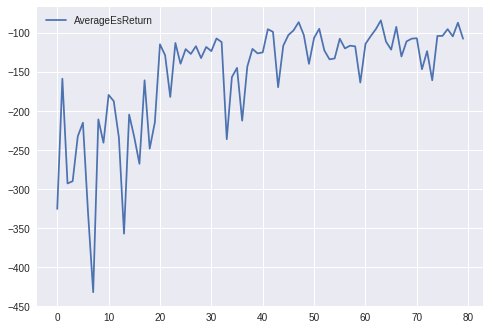

In [26]:
import os.path as osp
import numpy as np
import csv
import matplotlib.pyplot as plt
import json
import joblib
from glob import glob
import os

# mypath = './acrobot_dqn_plus/'

plots = []
legends = []
returns = []
with open(osp.join(mypath, 'progress.csv'), 'rt') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['AverageEsReturn']:
            returns.append(float(row['AverageEsReturn']))
returns = np.array(returns)
plots.append(plt.plot(returns)[0])
legends.append('AverageEsReturn')
plt.legend(plots, legends)
plt.show()

**4. Play Videos of your Agent Behavior**

- You can watch how your agent's behavior improves.
- If you haven't update 'mypath' in the code above, you need to update it here.
- (/content/acrobot_dqn_plus/)

In [0]:
from IPython import display as pythondisplay
# from pyvirtualdisplay import Display

# from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

import imageio

from os import listdir
from os.path import isfile, join

def plot_movie_js(image_array, filename):
    dpi = 10.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/(dpi), xpixels/(dpi)), dpi=dpi)
    fig.suptitle(filename, fontsize=160)
    # fig.set_xlabel(filename, fontsize=160)
    # fig.xlabel(filename, fontsize=160)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    pythondisplay.display(IPython_display.display_animation(anim))

# mypath = './acrobot_dqn_plus/'
mypath += 'gym_log/'
mp4files = [f for f in listdir(mypath) if f.endswith(".mp4")]
mp4files.sort()


for filename in mp4files:
    vid = imageio.get_reader(join(mypath, filename),  'ffmpeg')
    # print(len(vid))
    # print(vid.get_data(0).shape)

    screenlist = []
    for i in range(len(vid)):
        image = vid.get_data(i)
        screenlist.append(image)
        # fig = plt.figure()
        # fig.suptitle('image #{}'.format(i), fontsize=20)
        # plt.imshow(image)

    plot_movie_js(screenlist, filename)
